In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import OrderedDict, Counter, defaultdict

import torch
from transformers import AutoTokenizer, AutoModel, GPT2Tokenizer, GPT2LMHeadModel, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Data

In [ ]:
df_path = '/content/our_sentences_probs_revised.csv'
df = pd.read_csv(df_path)

df.head(5)

,sentence_pair,subjects_majority_vote,sentence1,sentence2,probability_sentence1,probability_sentence2
0,A message has been sent to your account_They a...,1.0,A message has been sent to your account,They are barely able to handle Delhi properly,-22.974640,-41.379484
1,A road closure is unlikely to impact service_I...,1.0,A road closure is unlikely to impact service,It allows tungsten are forecast to impact lauded,-37.691851,-74.207626
2,A whole history of kisses just so right_Our cu...,2.0,A whole history of kisses just so right,Our current culture of diversity is cut short,-51.102140,-33.978375
3,About christmas around thanksgiving was really...,2.0,About christmas around thanksgiving was really...,But stuffing onboard beds was fairly commonpla...,-63.069314,-59.383499
4,After reward yourself with whatever floats you...,1.0,After reward yourself with whatever floats you...,The Queen turning The Man into a throne,-40.996202,-48.385471


In [ ]:
df['Model_sentence_selected'] = df.apply(lambda row: 1.0 if row['probability_sentence1'] > row['probability_sentence2'] else 2.0, axis=1)
df['Match'] = df.apply(lambda row: 'Y' if row['Model_sentence_selected'] == row['subjects_majority_vote'] else 'N', axis=1)

In [ ]:
# Filter rows where the match column is N to research
df_no_match = df[df['Match'] == 'N']
df_match = df[df['Match'] == 'Y']

df_no_match.head(5) # 243 out of 1485 rows (revised = 222)

,sentence_pair,subjects_majority_vote,sentence1,sentence2,probability_sentence1,probability_sentence2,Model_sentence_selected,Match
5,Afterward my arm was ready to fall off_Half my...,1.0,Afterward my arm was ready to fall off,Half my heart was about to break open,-34.901520,-30.706158,2.0,N
17,And professional entrepreneurs tend to take bu...,1.0,And professional entrepreneurs tend to take bu...,And psychiatric doctors tend to take things se...,-39.104414,-36.569519,2.0,N
20,And the whole thing has been hypocritical whin...,1.0,And the whole thing has been hypocritical whining,Native to Northern India but now widespread gl...,-40.059843,-37.262473,2.0,N
43,Commenting to find out later what this is_Memp...,1.0,Commenting to find out later what this is,Memphis always seems to play the Jazz tough,-41.256134,-37.660075,2.0,N
51,Enjoy Looking At All Your Videos And Pictures_...,2.0,Enjoy Looking At All Your Videos And Pictures,Not sure why ppl are down voting you,-42.306932,-44.729846,1.0,N


In [ ]:
df_no_match.loc[:, 'wrong_sentence'] = df_no_match.apply(lambda row: row['sentence1'] if row['Model_sentence_selected'] == 1.0 else row['sentence2'], axis=1)
df_match.loc[:, 'right_sentence'] = df_match.apply(lambda row: row['sentence1'] if row['Model_sentence_selected'] == 1.0 else row['sentence2'], axis=1)

wrong_sentences = df_no_match['wrong_sentence']
right_sentences = df_match['right_sentence']


<ipython-input-6-7d763dd86515>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_match.loc[:, 'wrong_sentence'] = df_no_match.apply(lambda row: row['sentence1'] if row['Model_sentence_selected'] == 1.0 else row['sentence2'], axis=1)
<ipython-input-6-7d763dd86515>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match.loc[:, 'right_sentence'] = df_match.apply(lambda row: row['sentence1'] if row['Model_sentence_selected'] == 1.0 else row['sentence2'], axis=1)


# Load in transformer to interpret unmatched sentences

In [ ]:
# Initialize tokenizer and set the padding token
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")  # or "gpt2-xl" for the larger model
tokenizer.pad_token = tokenizer.eos_token  # Set the end-of-text token as the padding token

# Modify the tokenize function to handle a list of dictionaries
def tokenize(batch):
    texts = [item["text"] for item in batch]  # Extract text from each dictionary
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device) # change to gpt-xl when running for real

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

# Analysis methods

# 1. Parts of Speech (POS) Tagging

In [ ]:
nlp = spacy.load("en_core_web_sm")

def calculate_mean_pos_counts(sentences):
    # Initialize a list to store the POS count dictionaries for each sentence
    pos_counts_list = []

    for sentence in sentences:

        doc = nlp(sentence)
        pos_counts = {}

        for token in doc:
            pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1

        # Append the POS dictionary to the list
        pos_counts_list.append(pos_counts)

    # Convert the list of dictionaries into a dictionary of lists ;)
    pos_counts_combined = {}
    for pos_count in pos_counts_list:
        for pos, count in pos_count.items():
            if pos in pos_counts_combined:
                pos_counts_combined[pos].append(count)
            else:
                pos_counts_combined[pos] = [count]

    # Calculate the mean POS count for each POS tag and round to 2 decimals
    mean_pos_counts = {pos: round(np.mean(counts), 2) for pos, counts in pos_counts_combined.items()}

    # Sort the dictionary by POS tag alphabetically
    mean_pos_counts_sorted = OrderedDict(sorted(mean_pos_counts.items()))

    return mean_pos_counts_sorted

# calculate means of POS lists based on sentences
mean_pos_counts_w = calculate_mean_pos_counts(wrong_sentences)
mean_pos_counts_r = calculate_mean_pos_counts(right_sentences)

print("Mean POS counts wrong sentences:", mean_pos_counts_w)
print("Mean POS counts right sentences:", mean_pos_counts_r)

Mean POS counts wrong sentences: OrderedDict([('ADJ', 1.18), ('ADP', 1.27), ('ADV', 1.22), ('AUX', 1.11), ('CCONJ', 1.03), ('DET', 1.17), ('INTJ', 1.0), ('NOUN', 1.95), ('NUM', 1.0), ('PART', 1.04), ('PRON', 1.4), ('PROPN', 1.63), ('PUNCT', 1.0), ('SCONJ', 1.09), ('VERB', 1.53), ('X', 1.0)])
Mean POS counts right sentences: OrderedDict([('ADJ', 1.23), ('ADP', 1.2), ('ADV', 1.25), ('AUX', 1.22), ('CCONJ', 1.03), ('DET', 1.18), ('INTJ', 1.04), ('NOUN', 1.86), ('NUM', 1.0), ('PART', 1.05), ('PRON', 1.47), ('PROPN', 1.5), ('PUNCT', 1.0), ('SCONJ', 1.02), ('VERB', 1.49)])


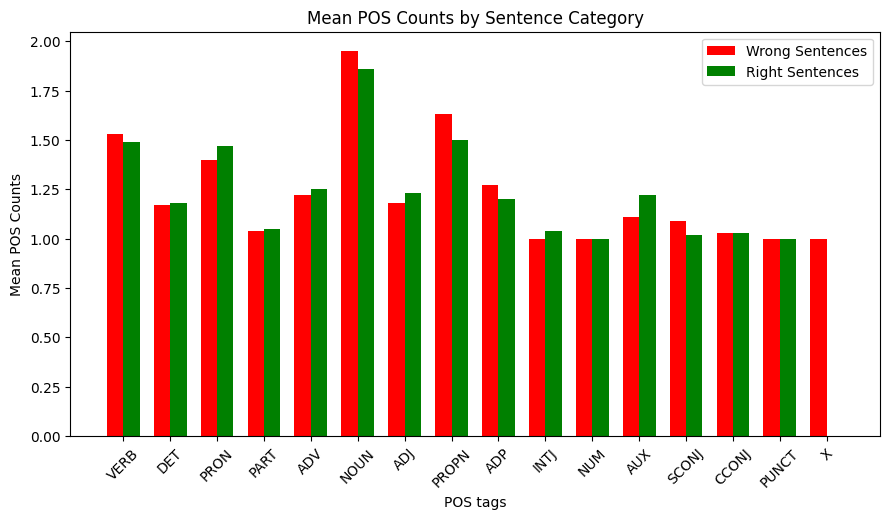

In [45]:
# Convert to lists for plotting
pos_tags = list(set(mean_pos_counts_w.keys()) | set(mean_pos_counts_r.keys()))
means_w = [mean_pos_counts_w.get(tag, 0) for tag in pos_tags]
means_r = [mean_pos_counts_r.get(tag, 0) for tag in pos_tags]

# Plotting
x = np.arange(len(pos_tags))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))
rects1 = ax.bar(x - width/2, means_w, width, label='Wrong Sentences', color = 'red')
rects2 = ax.bar(x + width/2, means_r, width, label='Right Sentences', color = 'green')

# Set up plot
ax.set_ylabel('Mean POS Counts')
ax.set_xlabel('POS tags')
ax.set_title('Mean POS Counts by Sentence Category')
ax.set_xticks(x)
ax.set_xticklabels(pos_tags)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

# 2. Sentiment Analysis


In [ ]:
# Initialize the pipeline for emotion analysis
emotion_pipeline = pipeline("text-classification", model="nateraw/bert-base-uncased-emotion")

# Convert to strings
wrong_sentences = [str(sentence) for sentence in wrong_sentences]
right_sentences = [str(sentence) for sentence in right_sentences]

# Function to analyze emotions and get distribution
def analyze_emotions(sentences):

    emotions = emotion_pipeline(sentences)
    emotion_distribution = {}

    # Aggregate results
    for emotion in emotions:
        label = emotion['label']

        # Increment the count for the observed emotion
        emotion_distribution[label] = emotion_distribution.get(label, 0) + 1

    return emotion_distribution

# Analyze emotions for wrong and right sentences
emotion_distribution_w = analyze_emotions(wrong_sentences)
emotion_distribution_r = analyze_emotions(right_sentences)

print("Emotion distribution for wrong sentences:", emotion_distribution_w)
print("Emotion distribution for right sentences:", emotion_distribution_r)

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Emotion distribution for wrong sentences: {'sadness': 14, 'joy': 128, 'anger': 64, 'fear': 14, 'surprise': 2}
Emotion distribution for right sentences: {'anger': 326, 'fear': 48, 'sadness': 63, 'joy': 807, 'surprise': 7, 'love': 12}


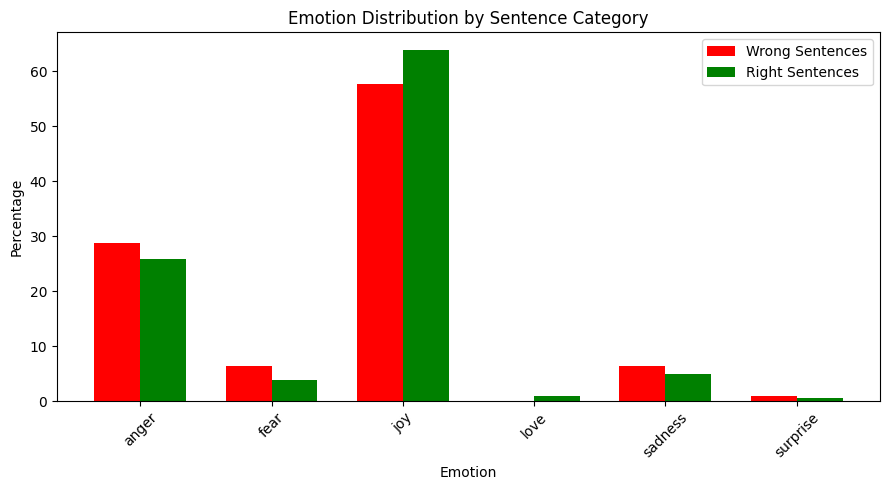

In [46]:
# Calculate the total count for wrong and right sentences
total_w = sum(emotion_distribution_w.values())
total_r = sum(emotion_distribution_r.values())

# Calculate the percentage of each emotion
emotion_percent_w = {emotion: (count / total_w) * 100 for emotion, count in emotion_distribution_w.items()}
emotion_percent_r = {emotion: (count / total_r) * 100 for emotion, count in emotion_distribution_r.items()}

# Prepare the plot
fig, ax = plt.subplots(figsize=(9, 5))

# Emotion categories
emotions = list(set(emotion_percent_w.keys()) | set(emotion_percent_r.keys()))
emotions.sort()

# Data for plotting
width = 0.35
ind = range(len(emotions))

# Bars for wrong and right sentences
bars_w = [emotion_percent_w.get(emotion, 0) for emotion in emotions]
bars_r = [emotion_percent_r.get(emotion, 0) for emotion in emotions]

# Plot bars
rects1 = ax.bar(ind, bars_w, width, label='Wrong Sentences', color='red')
rects2 = ax.bar([p + width for p in ind], bars_r, width, label='Right Sentences', color='green')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Emotion')
ax.set_ylabel('Percentage')
ax.set_title('Emotion Distribution by Sentence Category')
ax.set_xticks([p + width / 2 for p in ind])
ax.set_xticklabels(emotions)
ax.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Syntactic Dependency Parsing

In [ ]:
nlp = spacy.load("en_core_web_sm")

def analyze_dependencies(sentences):

    # Analyzes the dependencies in sentences and returns a Counter object representing the frequency of each dependency type across all sentences.
    dep_types = [token.dep_ for sentence in sentences for token in nlp(sentence)]
    return Counter(dep_types)

# Analyze both dependencies
dep_counters_wrong = analyze_dependencies(wrong_sentences)
dep_counters_right = analyze_dependencies(right_sentences)



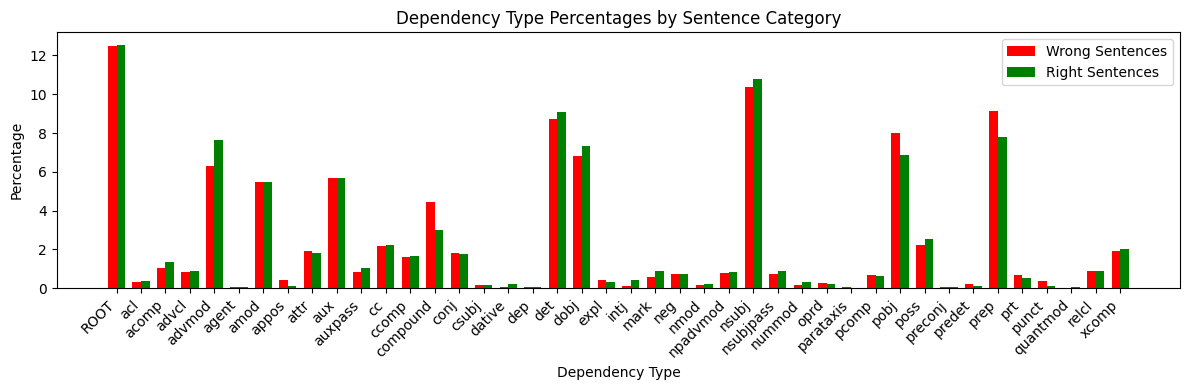

In [38]:
## Plot Dependency Frequencies for Comparison
def plot_dependency_comparison(dep_counter_wrong, dep_counter_right):
    fig, ax = plt.subplots(figsize=(12, 4))

    # Collect all unique dependencies in both groups
    all_deps = set(dep_counter_wrong.keys()).union(set(dep_counter_right.keys()))
    all_deps = sorted(list(all_deps))

    # Frequencies for plotting
    frequencies_wrong = np.array([dep_counter_wrong.get(dep, 0) for dep in all_deps])
    frequencies_right = np.array([dep_counter_right.get(dep, 0) for dep in all_deps])

    # Normalize frequencies to percentages
    frequencies_wrong = (frequencies_wrong / frequencies_wrong.sum()) * 100
    frequencies_right = (frequencies_right / frequencies_right.sum()) * 100

    # Plotting
    ind = np.arange(len(all_deps))
    width = 0.35

    rects1 = ax.bar(ind - width/2, frequencies_wrong, width, label='Wrong Sentences', color='red')
    rects2 = ax.bar(ind + width/2, frequencies_right, width, label='Right Sentences', color='green')

    ax.set_xlabel('Dependency Type')
    ax.set_ylabel('Percentage')
    ax.set_title('Dependency Type Percentages by Sentence Category')
    ax.set_xticks(ind)
    ax.set_xticklabels(all_deps, rotation=45, ha="right")
    ax.legend()

    plt.tight_layout()
    plt.show()

# Show final plot
plot_dependency_comparison(dep_counters_wrong, dep_counters_right)

# 4. Language Modeling & Perplexity

In [ ]:
# Load models
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define perplexity calculator
def calculate_perplexity(sentence):
    tokenize_input = tokenizer.encode(sentence, return_tensors="pt")
    loss = model(tokenize_input, labels=tokenize_input).loss
    return torch.exp(loss).item()

In [ ]:
# Calculate perplexities for wrong sentences
perplexities_wrong = [calculate_perplexity(sentence) for sentence in wrong_sentences]

# Calculate perplexities for right sentences
perplexities_right = [calculate_perplexity(sentence) for sentence in right_sentences]

# Calculate relative weights to total
weights_wrong = np.ones_like(perplexities_wrong) / len(perplexities_wrong)
weights_right = np.ones_like(perplexities_right) / len(perplexities_right)

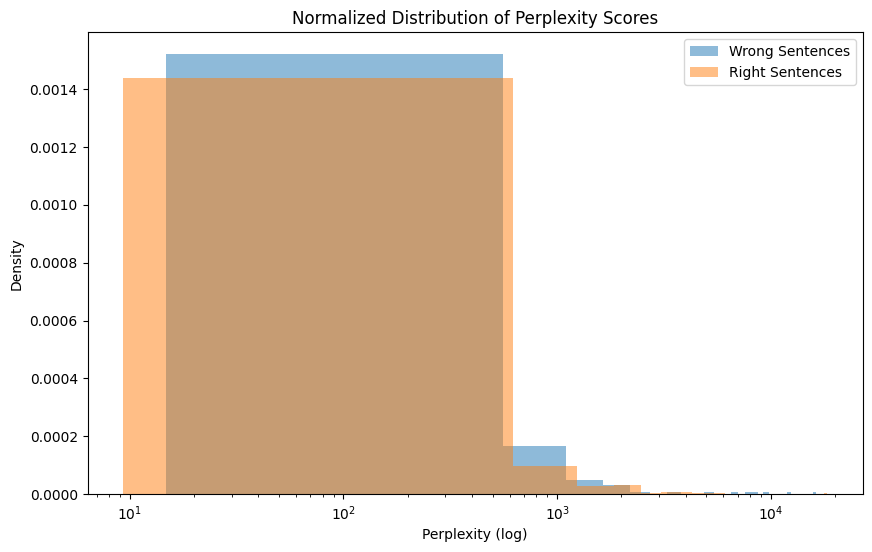

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(perplexities_wrong, alpha=0.5, bins=30, weights=weights_wrong, label='Wrong Sentences', density=True)
plt.hist(perplexities_right, alpha=0.5, bins=30, weights=weights_right, label='Right Sentences', density=True)
plt.xlabel('Perplexity (log)')
plt.ylabel('Density')
plt.title('Normalized Distribution of Perplexity Scores')
plt.legend()
plt.xscale('log')
plt.show()

In [ ]:
# Count the number of sentences with perplexity > 5000
num_high_perplexity_wrong = sum(p > 5000 for p in perplexities_wrong)
num_high_perplexity_right = sum(p > 5000 for p in perplexities_right)

# Calculate the percentages
percent_high_perplexity_wrong = (num_high_perplexity_wrong / len(perplexities_wrong)) * 100
percent_high_perplexity_right = (num_high_perplexity_right / len(perplexities_right)) * 100

print(f"Percentage of 'wrong' sentences with perplexity > 5000: {round(percent_high_perplexity_wrong, 2)}%")
print(f"Percentage of 'right' sentences with perplexity > 5000: {round(percent_high_perplexity_right, 2)}%")

Percentage of 'wrong' sentences with perplexity > 5000: 3.15%
Percentage of 'right' sentences with perplexity > 5000: 0.87%


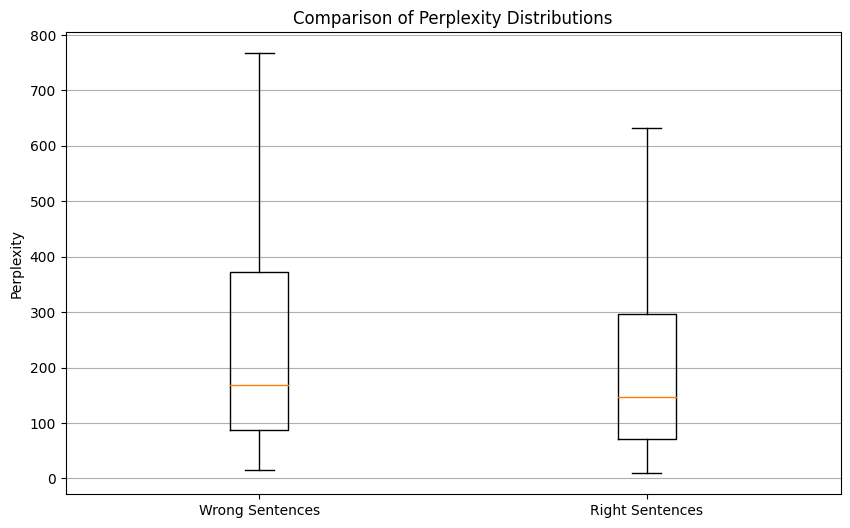

In [ ]:
data = [perplexities_wrong, perplexities_right]
labels = ['Wrong Sentences', 'Right Sentences']

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, showfliers=False)
plt.ylabel('Perplexity')
plt.title('Comparison of Perplexity Distributions')
plt.grid(axis='y')
plt.show()

# Comparison between delta perplexities sentence pairs

In [19]:
# Initialize the tokenizer and model again for safety
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define the perplexity calculation function againb
def calculate_perplexity(sentence):
    tokenize_input = tokenizer.encode(sentence, return_tensors="pt")
    with torch.no_grad():
        loss = model(tokenize_input, labels=tokenize_input).loss
    return torch.exp(loss).item()

# Convert sentences to string (if not already done before)
df['sentence1'] = df['sentence1'].astype(str)
df['sentence2'] = df['sentence2'].astype(str)

# Calculate perplexities for each sentence, storing it in columns
df['perplexity_sentence1'] = df['sentence1'].apply(calculate_perplexity)
df['perplexity_sentence2'] = df['sentence2'].apply(calculate_perplexity)

# Calculate absolute delta perplexity
df['delta_perplexity'] = abs(df['perplexity_sentence1'] - df['perplexity_sentence2'])

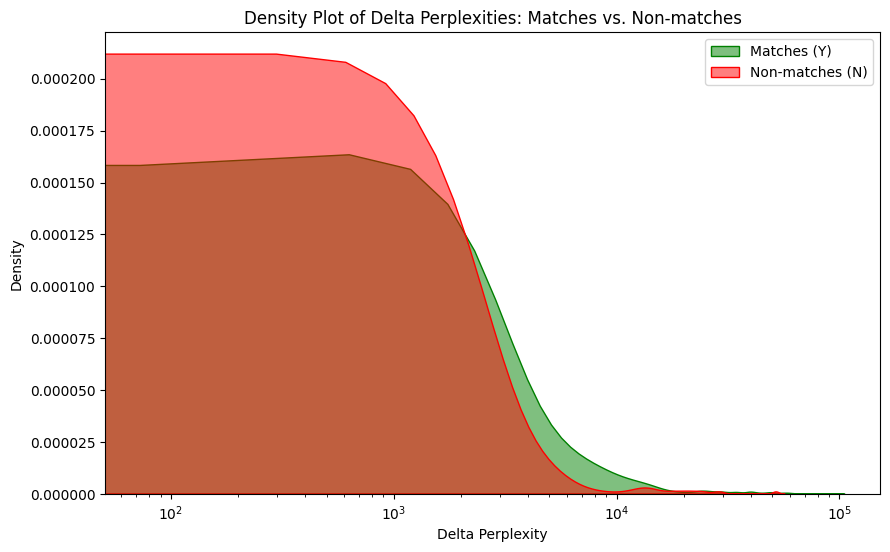

In [32]:
# Filter the DataFrame for matches and non-matches
matches = df[df['Match'] == 'Y']['delta_perplexity']
non_matches = df[df['Match'] == 'N']['delta_perplexity']

# Plotting
plt.figure(figsize=(10, 6))
sns.kdeplot(matches, label='Matches (Y)', fill=True, common_norm=False, alpha=0.5, color='green')
sns.kdeplot(non_matches, label='Non-matches (N)', fill=True, common_norm=False, alpha=0.5, color='red')
plt.title('Density Plot of Delta Perplexities: Matches vs. Non-matches')
plt.xlabel('Delta Perplexity')
plt.ylabel('Density')
plt.legend()
plt.xscale('log')
plt.show()


In [21]:
# Mean delta perplexity for matches
mean_delta_perplexity_matches = df[df['Match'] == 'Y']['delta_perplexity'].mean()

# Mean delta perplexity for non-matches
mean_delta_perplexity_non_matches = df[df['Match'] == 'N']['delta_perplexity'].mean()

# Round to 2 dec
mean_delta_perplexity_matches_rounded = round(mean_delta_perplexity_matches, 2)
mean_delta_perplexity_non_matches_rounded = round(mean_delta_perplexity_non_matches, 2)

sentence = f"The mean delta perplexity for matches is {round(mean_delta_perplexity_matches, 2)}, and for non-matches, it is {round(mean_delta_perplexity_non_matches, 2)}."
print(sentence)

The mean delta perplexity for matches is 2990.39, and for non-matches, it is 1342.23.


# Differences between Cosine similarities of sentence pair embeddings

In [22]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Calculate cosine similarity
def calculate_cosine_similarity(embeddings1, embeddings2):
    # Cosine similarity between two sets of embeddings
    return cosine_similarity(embeddings1, embeddings2)[0][0]

# Generate embeddings
embeddings_sentence1 = model.encode(df['sentence1'].tolist())
embeddings_sentence2 = model.encode(df['sentence2'].tolist())

# Calculate cosine similarity for each pair of sentences
df['cosine_similarity'] = [calculate_cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))
                           for embedding1, embedding2 in zip(embeddings_sentence1, embeddings_sentence2)]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

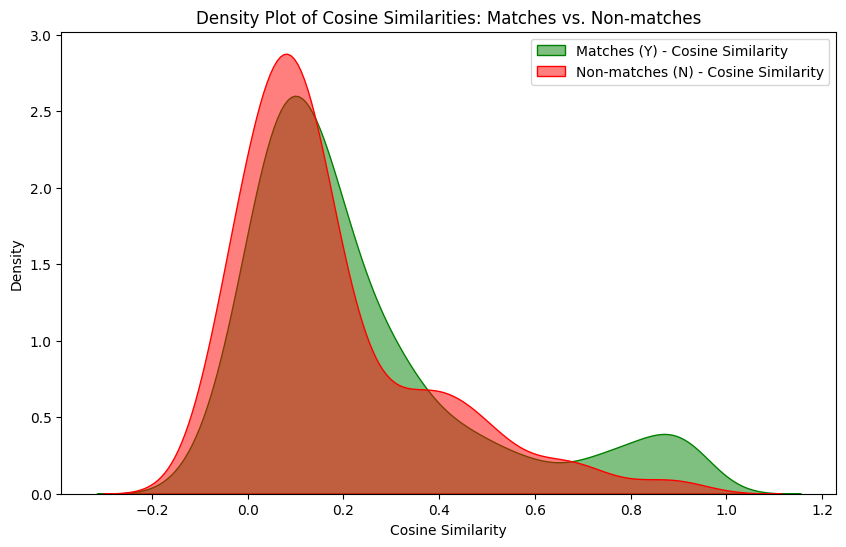

In [35]:
# Filter the DataFrame for matches and non-matches on cosine_similarity
cosine_similarity_matches = df[df['Match'] == 'Y']['cosine_similarity']
cosine_similarity_non_matches = df[df['Match'] == 'N']['cosine_similarity']

# Plotting for Cosine Similarity
plt.figure(figsize=(10, 6))
sns.kdeplot(cosine_similarity_matches, label='Matches (Y) - Cosine Similarity', fill=True, common_norm=False, alpha=0.5, color='green')
sns.kdeplot(cosine_similarity_non_matches, label='Non-matches (N) - Cosine Similarity', fill=True, common_norm=False, alpha=0.5, color='red')
plt.title('Density Plot of Cosine Similarities: Matches vs. Non-matches')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

In [24]:
# Mean cosine similarity for matches and non-matches
mean_cosine_similarity_matches = df[df['Match'] == 'Y']['cosine_similarity'].mean()
mean_cosine_similarity_non_matches = df[df['Match'] == 'N']['cosine_similarity'].mean()

# Round both to 2 dec
mean_cosine_similarity_matches_rounded = round(mean_cosine_similarity_matches, 2)
mean_cosine_similarity_non_matches_rounded = round(mean_cosine_similarity_non_matches, 2)

sentence_cosine = f"The mean cosine similarity for matches is {mean_cosine_similarity_matches_rounded}, and for non-matches, it is {mean_cosine_similarity_non_matches_rounded}."
print(sentence_cosine)

The mean cosine similarity for matches is 0.23000000417232513, and for non-matches, it is 0.17000000178813934.


## Impact perplexity on probabilty

In [25]:
def select_wrong_probability(row):
    if row['Model_sentence_selected'] == 1.0:
        return row['probability_sentence1']
    else:
        return row['probability_sentence2']

# Set probabilities based on model
df_no_match['probability'] = df_no_match.apply(select_wrong_probability, axis=1)

# Create new df and store correctly
df_wrong_sentences = df_no_match[['wrong_sentence', 'probability']].copy()

df_wrong_sentences.head(5)

<ipython-input-25-ede036278b5f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_match['probability'] = df_no_match.apply(select_wrong_probability, axis=1)


,wrong_sentence,probability
5,Half my heart was about to break open,-30.706158
17,And psychiatric doctors tend to take things se...,-36.569519
20,Native to Northern India but now widespread gl...,-37.262473
43,Memphis always seems to play the Jazz tough,-37.660075
51,Enjoy Looking At All Your Videos And Pictures,-42.306932


In [26]:
# Load models
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define perplexity calculator
def calculate_perplexity(sentence):
    tokenize_input = tokenizer.encode(sentence, return_tensors="pt")
    loss = model(tokenize_input, labels=tokenize_input).loss
    return torch.exp(loss).item()

# Compute Perplexity
df_wrong_sentences['Perplexity'] = df_wrong_sentences['wrong_sentence'].apply(calculate_perplexity)

df_wrong_sentences.head(5)

,wrong_sentence,probability,Perplexity
5,Half my heart was about to break open,-30.706158,73.259422
17,And psychiatric doctors tend to take things se...,-36.569519,177.712524
20,Native to Northern India but now widespread gl...,-37.262473,416.127625
43,Memphis always seems to play the Jazz tough,-37.660075,366.458893
51,Enjoy Looking At All Your Videos And Pictures,-42.306932,247.397736


In [ ]:
# Load the sentence transformer model to define semantic coherence
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to calculate semantic coherence as cosine similarity to the baseline sentence
def calculate_semantic_coherence(sentence, baseline_embedding):
    sentence_embedding = model.encode(sentence)
    cosine_sim = cosine_similarity(sentence_embedding.reshape(1, -1), baseline_embedding.reshape(1, -1))[0][0]
    return cosine_sim


# A generic baseline sentence for comparison
baseline_sentence = "This sentence speaks about an aspect of life, knowledge, or experience."
baseline_embedding = model.encode(baseline_sentence)

df_wrong_sentences['Semantic_Coherence'] = df_wrong_sentences['wrong_sentence'].apply(lambda x: calculate_semantic_coherence(x, baseline_embedding))

df_wrong_sentences.head(5)

#### Perplexity only

In [ ]:
X = df_wrong_sentences['Perplexity']
y = df_wrong_sentences['probability']
X_reshaped = X.values.reshape(-1, 1)

# Transform Perplexity into poly
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_reshaped)
model_poly = LinearRegression()
model_poly.fit(X_poly, y)
y_pred = model_poly.predict(X_poly)

# Calculate MSE and R2
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# For plotting the regression curve
X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_line_poly = poly.transform(X_line)
y_line_poly = model_poly.predict(X_line_poly)

# Plot
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X_line.flatten(), y_line_poly, color='red', label='Regression Curve')  # Ensure X_line is flattened for correct plotting
plt.xlabel('Perplexity')
plt.ylabel('Probability')
plt.title('Non-Linear Regression: Probability vs Perplexity')
plt.legend()
plt.show()

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

#### Semantic Coherence only

In [ ]:
X = df_wrong_sentences['Semantic_Coherence']
y = df_wrong_sentences['probability']
X_reshaped = X.values.reshape(-1, 1)

# Transform Perplexity into poly
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_reshaped)
model_poly = LinearRegression()
model_poly.fit(X_poly, y)
y_pred = model_poly.predict(X_poly)

# Calculate MSE and R2
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# For plotting the regression curve
X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_line_poly = poly.transform(X_line)
y_line_poly = model_poly.predict(X_line_poly)

# Plot
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X_line.flatten(), y_line_poly, color='red', label='Regression Curve')  # Ensure X_line is flattened for correct plotting
plt.xlabel('Semantic_Coherence')
plt.ylabel('Probability')
plt.title('Non-Linear Regression: Probability vs Semantic_Coherence')
plt.legend()
plt.show()

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

#### Both

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


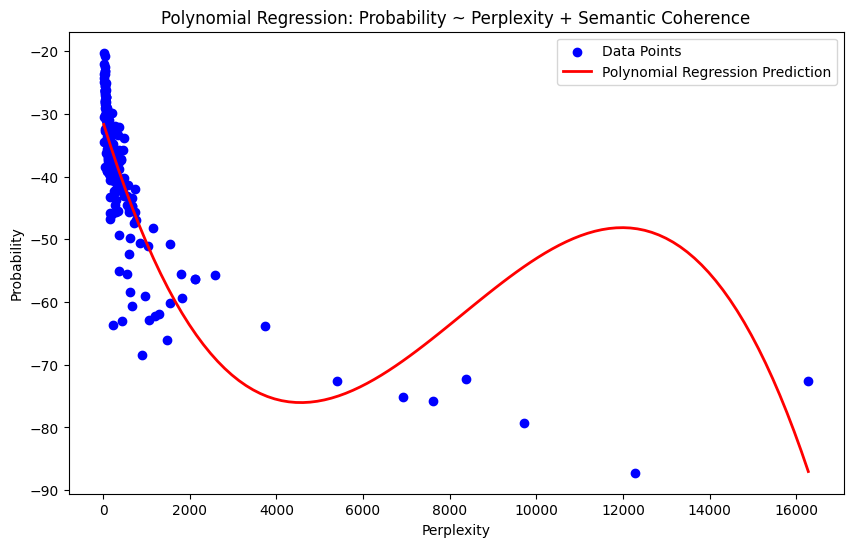

Mean Squared Error: 33.72113161935048
R^2 Score: 0.749072840105746


In [30]:
# Independent variables are Perplexity and Semantic_Coherence
X = df_wrong_sentences[['Perplexity', 'Semantic_Coherence']]
y = df_wrong_sentences['probability']

# Create polynomial features
degree = 3
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly_features.fit_transform(X)

# Init Polynomial regression model (Linear Regression with Polynomial Features)
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly, y)

# Generate a sequence of Perplexity and SC values for prediction
perplexity_range = np.linspace(X['Perplexity'].min(), X['Perplexity'].max(), 100)
mean_semantic_coherence = np.mean(X['Semantic_Coherence'])
grid = np.array([[perplexity, mean_semantic_coherence] for perplexity in perplexity_range])
grid_poly = poly_features.transform(grid)

# Predictions for the grid
y_pred_poly = poly_reg_model.predict(X_poly)
y_pred_poly_grid = poly_reg_model.predict(grid_poly)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X['Perplexity'], y, color='blue', label='Data Points')
plt.plot(perplexity_range, y_pred_poly_grid, color='red', label='Polynomial Regression Prediction', linewidth=2)
plt.xlabel('Perplexity')
plt.ylabel('Probability')
plt.title('Polynomial Regression: Probability ~ Perplexity + Semantic Coherence')
plt.legend()
plt.show()

# Mean Squared Error and R^2 Score for Polynomial Regression
mse_poly = mean_squared_error(y, y_pred_poly)
r2_poly = r2_score(y, y_pred_poly)

print("Mean Squared Error:", mse_poly)
print("R^2 Score:", r2_poly)